In [1]:
!pip install -q torch-scatter -f https://pytorch-geometric.com/whl/torch-1.8.0+cu101.html
!pip install -q torch-sparse -f https://pytorch-geometric.com/whl/torch-1.8.0+cu101.html
!pip install -q torch-geometric
!pip install -q git+https://github.com/snap-stanford/deepsnap.git

     |████████████████████████████████| 2.6MB 1.7MB/s 
     |████████████████████████████████| 1.5MB 1.9MB/s 
     |████████████████████████████████| 215kB 5.8MB/s 
     |████████████████████████████████| 235kB 7.6MB/s 
     |████████████████████████████████| 2.2MB 7.8MB/s 
     |████████████████████████████████| 51kB 7.7MB/s 


In [35]:
import copy
import torch
import torch.nn as nn
import networkx as nx
import torch.nn.functional as F
import matplotlib.pyplot as plt
import torch.optim as optim

from deepsnap.graph import Graph
from deepsnap.batch import Batch
from deepsnap.dataset import GraphDataset
from torch.utils.data import DataLoader
import torch_geometric.nn as pyg_nn
import matplotlib.pyplot as plt

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [51]:
# Read NetworkX graph of restaurants
# No features: restaurants_no_features.gpickle
# Basic features: restaurants_basic_features.gpickle
# With node degree: restaurants_node_degree.gpickle
# With categories (top 20) and node degree + attributes: restaurants_with_categories.gpickle
# With categories (top 50) and node degree + attributes: restaurants_with_categories50.gpickle"
# With categories (top 50) + node degree + attributes + clustering coeffs: restaurants_with_cluster.gpickle

G = nx.read_gpickle("./drive/MyDrive/Colab Notebooks/restaurants_with_cluster.gpickle")

In [52]:
G.nodes[0]

{'node_feature': tensor([ 2.0000,  1.0000,  1.0000,  1.0000,  0.0000,  1.0000,  1.0000,  1.0000,
          1.0000,  1.0000,  1.0000,  1.0000,  0.0000,  0.0000,  0.0000,  0.0000,
          0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
          0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  1.0000,
          0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
          0.0000,  1.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
          0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
          0.0000, 73.0000,  0.9600]), 'node_label': 2}

In [53]:
G.number_of_nodes()

29963

In [54]:
G.number_of_edges()

491464

In [55]:
class GNN(torch.nn.Module):
    def __init__(self, input_size, hidden_size, output_size, args):
        super(GNN, self).__init__()
        self.num_layers = args["num_layers"]

        conv_model = self.build_conv_model(args["model"])
        self.convs = nn.ModuleList()
        self.convs.append(conv_model(input_size, hidden_size))

        for l in range(self.num_layers - 1):
            self.convs.append(conv_model(hidden_size, hidden_size))
        self.post_mp = nn.Linear(hidden_size, output_size)

    def forward(self, data):
        x, edge_index, batch = data.node_feature, data.edge_index, data.batch

        for i in range(len(self.convs) - 1):
            x = self.convs[i](x, edge_index)
            x = F.leaky_relu(x)
        x = self.convs[-1](x, edge_index)
        x = F.log_softmax(x, dim=1)
        return x

    def loss(self, pred, label):
        return F.nll_loss(pred, label)

    def build_conv_model(self, model_type):
        if model_type == 'GCN':
            return pyg_nn.GCNConv
        elif model_type == 'GAT':
            return pyg_nn.GATConv
        elif model_type == "GraphSage":
            return pyg_nn.SAGEConv
        else:
            raise ValueError(
                "Model {} unavailable, please add it to GNN.build_conv_model.".format(model_type))

In [56]:
def train(train_loader, val_loader, test_loader, args, num_node_features, num_classes,
          device="cpu"):
    model = GNN(num_node_features, args['hidden_size'], num_classes, args).to(device)
    print(model)
    optimizer = optim.Adam(model.parameters(), lr=args['lr'], weight_decay=5e-4)
    losses = []
    accuracies = []

    for epoch in range(args['epochs']):
        total_loss = 0
        model.train()
        for batch in train_loader:
            batch.to(device)
            optimizer.zero_grad()
            pred = model(batch)
            label = batch.node_label
            loss = model.loss(pred[batch.node_label_index], label)
            total_loss += loss.item()
            loss.backward()
            optimizer.step()

        train_acc = round(test(train_loader, model, device), 4)
        val_acc = round(test(val_loader, model, device), 4)
        test_acc = round(test(test_loader, model, device), 4)

        if epoch % 5 == 0:
          print(f"Epoch {epoch + 1}: Train: {train_acc}, Validation: {val_acc}. Test: {test_acc}, Loss: {round(total_loss, 4)}")

        losses.append(round(total_loss, 4))
        accuracies.append(test_acc)

    return (model, losses, accuracies)

def test(loader, model, device='cuda'):
    model.eval()
    for batch in loader:
        batch.to(device)
        logits = model(batch)
        pred = logits[batch.node_label_index].max(1)[1]
        acc = pred.eq(batch.node_label).sum().item()
        total = batch.node_label_index.shape[0]
        acc /= total
    return acc

In [57]:
args = {
    "device" : 'cuda' if torch.cuda.is_available() else 'cpu',
    "hidden_size" : 128,
    "epochs" : 250,
    "lr" : 0.01,
    "num_layers": 2,
    "model": "GraphSage" # [GraphSage, GAT, GCN]
}

H = Graph(G)
dataset = GraphDataset(graphs=[H], task='node')

dataset_train, dataset_val, dataset_test = dataset.split(transductive=True, split_ratio=[0.8, 0.1, 0.1])

train_loader = DataLoader(dataset_train, collate_fn=Batch.collate(), batch_size=16)
val_loader = DataLoader(dataset_val, collate_fn=Batch.collate(), batch_size=16)
test_loader = DataLoader(dataset_test, collate_fn=Batch.collate(), batch_size=16)

num_node_features = dataset_train.num_node_features
num_classes = dataset_train.num_node_labels
print(f"There are {num_node_features} features and {num_classes} labels.")

model, losses, accuracies = train(train_loader, val_loader, test_loader, args, num_node_features, num_classes, args["device"])

There are 59 features and 3 labels.
GNN(
  (convs): ModuleList(
    (0): SAGEConv(59, 128)
    (1): SAGEConv(128, 128)
  )
  (post_mp): Linear(in_features=128, out_features=3, bias=True)
)
Epoch 1: Train: 0.315, Validation: 0.3031. Test: 0.314, Loss: 7.4444
Epoch 6: Train: 0.3306, Validation: 0.3248. Test: 0.33, Loss: 2.0488
Epoch 11: Train: 0.4262, Validation: 0.4206. Test: 0.4231, Loss: 1.4029
Epoch 16: Train: 0.347, Validation: 0.3601. Test: 0.3624, Loss: 1.1462
Epoch 21: Train: 0.4432, Validation: 0.4349. Test: 0.4364, Loss: 1.178
Epoch 26: Train: 0.4516, Validation: 0.4533. Test: 0.4525, Loss: 1.126
Epoch 31: Train: 0.4941, Validation: 0.4853. Test: 0.4708, Loss: 1.0697
Epoch 36: Train: 0.4938, Validation: 0.497. Test: 0.4755, Loss: 1.016
Epoch 41: Train: 0.5062, Validation: 0.5093. Test: 0.4942, Loss: 0.9765
Epoch 46: Train: 0.5121, Validation: 0.506. Test: 0.4942, Loss: 0.9677
Epoch 51: Train: 0.5218, Validation: 0.519. Test: 0.5068, Loss: 0.9535
Epoch 56: Train: 0.5428, Validat

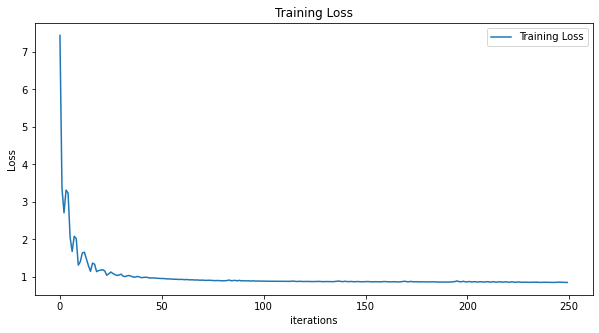

In [58]:
plt.figure(figsize=(10,5))
plt.title("Training Loss")
plt.plot(losses,label="Training Loss")
plt.xlabel("iterations")
plt.ylabel("Loss")
plt.legend()
plt.show()

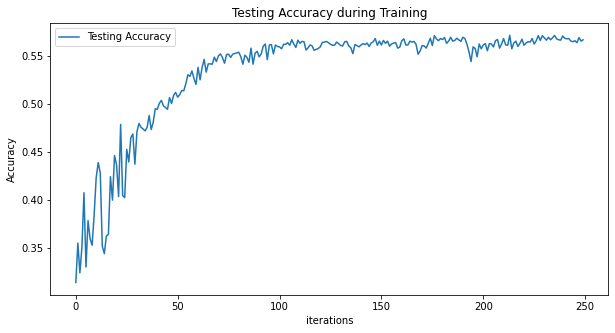

In [59]:
plt.figure(figsize=(10,5))
plt.title("Testing Accuracy during Training")
plt.plot(accuracies,label="Testing Accuracy")
plt.xlabel("iterations")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

In [68]:
def accuracy(pred, target):
    r"""Computes the accuracy of predictions.

    Args:
        pred (Tensor): The predictions.
        target (Tensor): The targets.

    :rtype: float
    """
    return round((pred == target).sum().item() / target.numel(), 4)



def true_positive(pred, target, num_classes):
    r"""Computes the number of true positive predictions.

    Args:
        pred (Tensor): The predictions.
        target (Tensor): The targets.
        num_classes (int): The number of classes.

    :rtype: :class:`LongTensor`
    """
    out = []
    for i in range(num_classes):
        out.append(((pred == i) & (target == i)).sum())

    return torch.tensor(out)



def true_negative(pred, target, num_classes):
    r"""Computes the number of true negative predictions.

    Args:
        pred (Tensor): The predictions.
        target (Tensor): The targets.
        num_classes (int): The number of classes.

    :rtype: :class:`LongTensor`
    """
    out = []
    for i in range(num_classes):
        out.append(((pred != i) & (target != i)).sum())

    return torch.tensor(out)



def false_positive(pred, target, num_classes):
    r"""Computes the number of false positive predictions.

    Args:
        pred (Tensor): The predictions.
        target (Tensor): The targets.
        num_classes (int): The number of classes.

    :rtype: :class:`LongTensor`
    """
    out = []
    for i in range(num_classes):
        out.append(((pred == i) & (target != i)).sum())

    return torch.tensor(out)



def false_negative(pred, target, num_classes):
    r"""Computes the number of false negative predictions.

    Args:
        pred (Tensor): The predictions.
        target (Tensor): The targets.
        num_classes (int): The number of classes.

    :rtype: :class:`LongTensor`
    """
    out = []
    for i in range(num_classes):
        out.append(((pred != i) & (target == i)).sum())

    return torch.tensor(out)


def precision(pred, target, num_classes):
    r"""Computes the precision
    :math:`\frac{\mathrm{TP}}{\mathrm{TP}+\mathrm{FP}}` of predictions.

    Args:
        pred (Tensor): The predictions.
        target (Tensor): The targets.
        num_classes (int): The number of classes.

    :rtype: :class:`Tensor`
    """
    tp = true_positive(pred, target, num_classes).to(torch.float)
    fp = false_positive(pred, target, num_classes).to(torch.float)

    out = tp / (tp + fp)
    out[torch.isnan(out)] = 0

    return out



def recall(pred, target, num_classes):
    r"""Computes the recall
    :math:`\frac{\mathrm{TP}}{\mathrm{TP}+\mathrm{FN}}` of predictions.

    Args:
        pred (Tensor): The predictions.
        target (Tensor): The targets.
        num_classes (int): The number of classes.

    :rtype: :class:`Tensor`
    """
    tp = true_positive(pred, target, num_classes).to(torch.float)
    fn = false_negative(pred, target, num_classes).to(torch.float)

    out = tp / (tp + fn)
    out[torch.isnan(out)] = 0

    return out



def f1_score(pred, target, num_classes):
    r"""Computes the :math:`F_1` score
    :math:`2 \cdot \frac{\mathrm{precision} \cdot \mathrm{recall}}
    {\mathrm{precision}+\mathrm{recall}}` of predictions.

    Args:
        pred (Tensor): The predictions.
        target (Tensor): The targets.
        num_classes (int): The number of classes.

    :rtype: :class:`Tensor`
    """
    prec = precision(pred, target, num_classes)
    rec = recall(pred, target, num_classes)

    score = 2 * (prec * rec) / (prec + rec)
    score[torch.isnan(score)] = 0

    return score

In [61]:
model.eval()
for batch in test_loader:
    batch.to("cuda")
    logits = model(batch)
    pred = logits[batch.node_label_index].max(1)[1]
    f1 = f1_score(pred, batch.node_label, num_classes)
    print(f1)

tensor([0.6368, 0.4017, 0.6455])


In [69]:
final_test_loader = DataLoader(dataset_test, collate_fn=Batch.collate(), batch_size=len(dataset_test))
model.eval()
for batch in final_test_loader:
    batch.to("cuda")
    logits = model(batch)
    pred = logits[batch.node_label_index].max(1)[1]
    
    testing_accuracy = accuracy(pred, batch.node_label)
    print(f"Accuracy on the whole testing set is: {testing_accuracy}")

Accuracy on the whole testing set is: 0.5666
